# Project Niagara
The ever-dynamic Asian telecommunication industry is facing stiff competition amongst
service providers with rapid introduction of innovative features and services such as airtime
transfer, data sharing, mobile money, location aware apps, advanced social networking, and
several OTT services. Fast growing telecom market in developing Asian countries is primarily
a prepaid connections market. Among the various ways to reload a prepaid mobile phone
through a refill card, online bank transfer, electronic reload at convenient store etc. peer to
peer airtime transfer is emerging as a popular option. Peer to peer transfer involves a
subscriber A transfer a part of their balance to subscriber B which can then be used for data,
SMS, or voice call.

### Challenge
The airtime transfer can be done in two ways: direct transfer and accepting a request for a
transfer. Direct transfer involves a subscriber A initiating a transfer directly to subscriber B.
Request transfer involves subscriber B raising a request for a certain amount from subscriber
A and then subscriber A either accepts or rejects the transfer request. Typically, the transfer is
done through an SMS in a specific format to a toll-free number. Many a times the transfer
fails for variety of reasons such as incorrect amount (Only integer amount of $1 - $25 is
allowed), incorrect mobile number, sending airtime to a post postpaid number, technical
glitches etc. <b>The objective of this data challenge is to characterize the users and identify
the drivers of airtime transfer to enhance the count and value of successful transactions.</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from tqdm.notebook import tqdm
from scipy.stats.stats import pearsonr
from sklearn import cluster, preprocessing, metrics, model_selection, tree
from bioinfokit.analys import stat

In [2]:
df = pd.read_csv('data/Sprint Data Set.csv')

In [3]:
# makes indexing easier
df.columns = [i.lower() for i in df.columns]

Let's start by dividing the columns into meta data (transactions) and customer data to avoid confusion.

In [4]:
cust_df = pd.DataFrame()
cust_df['uid'] = df.uid
cust_df['cnt_uid'] = df.cnt_uid
cust_df['activedays'] = df.activedays
cust_df['total_amt'] = df.total_amount

In [5]:
transaction_cols = [i for i in df.columns if 'mn' in i]
transactions_df = df.loc[:, ['uid'] + transaction_cols[8:]]

Also, since the data was collected in a real-time environment, there are a few cases where there are inconsistencies in the columns like `tx` and `success` which indicate the total number of transactions and total number of successful transactions respectively. Therefore, these columns are re-calculated from the rest of the data provided

*Note: This information was verified by the moderator of the competition.*

In [6]:
cust_df['tx'] = transactions_df.iloc[:,1:9].sum(axis=1)
cust_df['suc_tx'] = transactions_df.iloc[:,17:].sum(axis=1)

We start by investigating the transaction data, firstly let's check whether there are any users who don't have a single successful transaction

In [7]:
cust_df[cust_df.suc_tx == 0].shape[0] / cust_df.shape[0]

0.37119894148277777

Interestingly, 37% users don't even have a single successful transaction

Since, the customer-level transaction data is given for a period of 8 months, it would be interesting to see the month-wise trend in the data. This calculation is a bit complex and involves grouping and slicing operations.

Here's a look at the table

In [88]:
suc_cols = transactions_df.iloc[:,17:].columns

tx_mn = transactions_df[suc_cols].sum().reset_index(name='cnt')
tx_mn['tx_type'] = tx_mn['index'].apply(lambda x: x.split('_')[1])
tx_mn['month'] = tx_mn['index'].apply(lambda x: x.split('n')[1])

In [89]:
tx_mn = tx_mn.groupby(['tx_type', 'month'])['cnt'].sum().unstack('tx_type')

In [90]:
tx_mn

tx_type,ra,rb,ta,tb
month,,,,
1,634246,634246,7372594,7373422
2,507185,507184,6342612,6343615
3,538862,538862,6759832,6760975
4,490808,490807,6034889,6035866
5,478420,478418,6081518,6082517
6,405210,405210,5340496,5341387
7,406012,407809,5246627,5248129
8,52292,52528,673933,674155


Now for the trend

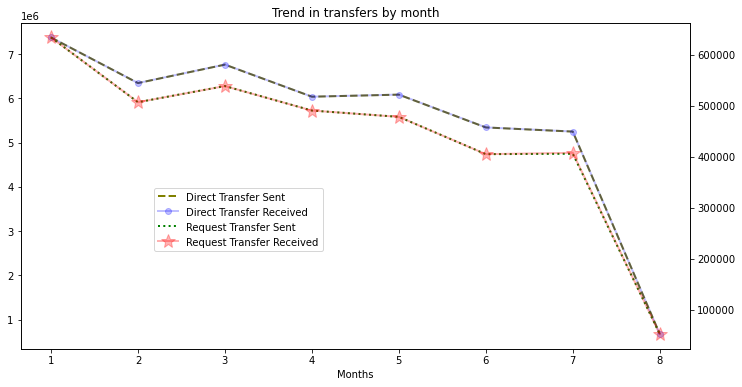

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))
ax1 = ax.twinx()

p1 = ax.plot(tx_mn.ta, data=tx_mn, marker='', markersize=15, color='olive', linewidth=2, 
             linestyle='dashed', label='Direct Transfer Sent')
p2 = ax.plot(tx_mn.tb, data=tx_mn, marker='o', color='blue', linewidth=2, 
             alpha=.25, label='Direct Transfer Received')

p3 = ax1.plot(tx_mn.ra, data=tx_mn, marker='', color='green', linewidth=2, 
              linestyle=':', label='Request Transfer Sent')
p4 = ax1.plot(tx_mn.rb, data=tx_mn, marker='*', markersize=15, color='red', 
              linewidth=2, alpha=.3, label='Request Transfer Received')

lns = p1 + p2 + p3 + p4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=[.2,.3])

plt.title('Trend in transfers by month');
ax.set_xlabel('Months');

plt.savefig('assets/month-trend-fig1.jpeg', bbox_inches='tight')

Overall there is a decreasing trend in the number of transactions across months

Previously created table would also help us determine what proportion of transactions are successful

In [12]:
tx_mn['suc_tx'] = tx_mn.sum(axis=1)

In [13]:
total_tx = transactions_df.iloc[:,1:9].sum()
tx_mn.suc_tx.sum() / total_tx.sum()

0.2586547689367111

On average, only 1 in 4 transactions is successful 

Let's also have a look at the proportion of direct and request transfers in our dataset

In [16]:
tx_mn.columns = ['sent_rqtx', 'rec_rqtx', 'sent_dttx', 'rec_dttx', 'suc_tx']
tx_mn['dtx_total'] = tx_mn['sent_dttx'] + tx_mn['rec_dttx']
tx_mn['rqtx_total'] = tx_mn['sent_rqtx'] + tx_mn['rec_rqtx']

In [17]:
(tx_mn.dtx_total.sum(), tx_mn.rqtx_total.sum()) / tx_mn.suc_tx.sum()

array([0.9258175, 0.0741825])

Here the values denote number of direct and request transfers respectively. Large proportion of customers prefer direct transfers over request transfers

Now that we understand the customer transactions better, let's have a look at the customer table and analyze if there's any relationship between the variables. More specifically we're aiming to see if any linear relationship exists among the columns.

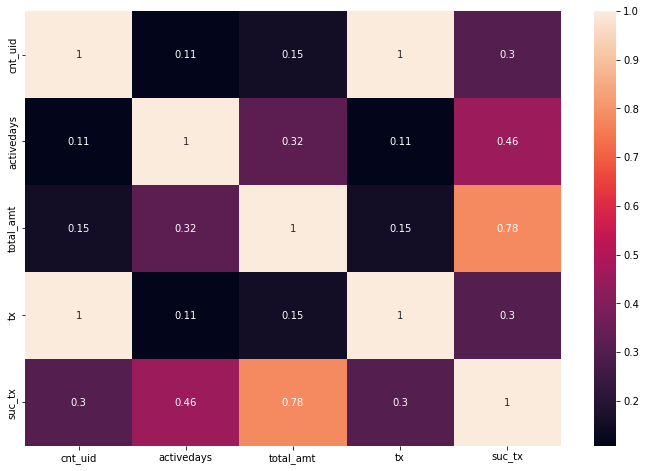

In [83]:
plt.figure(figsize=(12,8));
sns.heatmap(cust_df.iloc[:, 1:].corr(), annot=True);

plt.savefig('assets/cust-corr-fig2.jpeg', bbox_inches='tight')

In [19]:
pearsonr(cust_df.suc_tx, cust_df.total_amt)

(0.7827031132599644, 0.0)

- The above values indicate the correlation between successful transactions and the total amount transferred for a particular customer, and its corresponding p-value respectively. The values indicate that there is a significantly strong positive correlation between these columns.

- Also, from the heatmap it can be observed that majority of the transactions involve new people as `cnt_uid` column has a positive correlation with the total number of transactions.

Let's characterize the users using clustering. More specifically using KMeans clustering methodology. It is crucial to normalize the columns during preprocessing due to different scales, as KMeans is a distance-based algorithm

In [84]:
scaler = preprocessing.MinMaxScaler()
scaled_arr = scaler.fit_transform(cust_df)

scaled_arr.shape

(9371600, 6)

In [85]:
scaled_df = pd.DataFrame(scaled_arr, columns=cust_df.columns)

We use elbow-plot to determine the optimal number of clusters for KMeans

  0%|          | 0/10 [00:00<?, ?it/s]

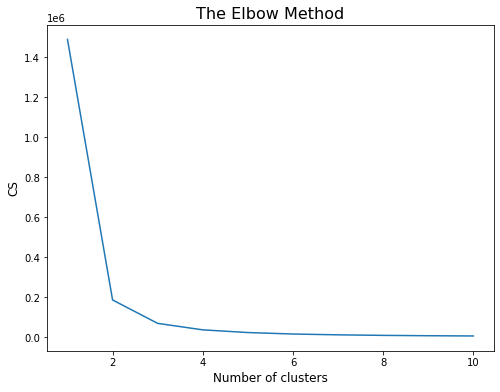

In [86]:
cs = []

values = range(1, 11)
with tqdm(total=len(values), file=sys.stdout) as pbar:
    for i in values:
        pbar.set_description(f"processing k={i}")
        pbar.update()
        
        kmeans = cluster.KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=42)
        kmeans.fit(scaled_df.iloc[:, 1:])
        cs.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method', fontsize=16)
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('CS', fontsize=12)

plt.savefig('assets/optimal-cluster-fig3.jpeg', bbox_inches='tight')

We observe from the above plot that 3 would be the optimal number of clusters for our case.

Fitting the algorithm...

In [93]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42) 
kmeans.fit(scaled_df.iloc[:,1:])

KMeans(n_clusters=3, random_state=42)

In [94]:
cust_df['cluster'] = kmeans.labels_
scaled_df['cluster'] = kmeans.labels_

In [95]:
cust_df.cluster.value_counts(normalize=True)

0    0.473282
1    0.357523
2    0.169195
Name: cluster, dtype: float64

Here's a look at the clusters and its characterics for different columns

In [25]:
df_mean = cust_df.groupby('cluster')[scaled_df.columns[1:-1]].mean()
df_mean

,cnt_uid,activedays,total_amt,tx,suc_tx
cluster,,,,,
0,4.327881,7.333546,6.427707,4.325501,1.112377
1,92.512831,193.516409,55.570050,91.677877,23.953850
2,25.305886,96.190044,20.740651,25.179140,6.021600


The clusters are quite different from each other with respect to the mean value of the features. However let's check if these differences are significant using ANOVA

In [186]:
values = cust_df.columns[1:-1]
with tqdm(total=len(values), file=sys.stdout) as pbar:
    for i in values:
        pbar.set_description(f"processing col={i}")
        pbar.update()
        
        res = stat()
        res.anova_stat(df=cust_df, res_var=i, anova_model=f'{i} ~ C(cluster)')
        print(f'\033[1m Col = {i} \033[0m')
        print(f'{res.anova_summary}\n')
        
        res.tukey_hsd(df=cust_df, res_var=i, xfac_var='cluster', anova_model=f'{i} ~ C(cluster)')
        print(f'{res.tukey_summary}\n\n')

  0%|          | 0/5 [00:00<?, ?it/s]

 Col = cnt_uid 
                   df        sum_sq       mean_sq             F  PR(>F)
C(cluster)        2.0  1.522260e+10  7.611302e+09  47570.489501     0.0
Residual    9371597.0  1.499460e+12  1.600005e+05           NaN     NaN

   group1  group2       Diff      Lower      Upper     q-value  p-value
0       2       0  20.978005  20.110581  21.845429   80.158685    0.001
1       2       1  67.206945  66.303296  68.110595  246.508642    0.001
2       0       1  88.184951  87.506381  88.863520  430.742777    0.001


 Col = activedays 
                   df        sum_sq       mean_sq             F  PR(>F)
C(cluster)        2.0  6.626394e+10  3.313197e+10  9.790829e+07     0.0
Residual    9371597.0  3.171330e+09  3.383980e+02           NaN     NaN

   group1  group2        Diff       Lower       Upper       q-value  p-value
0       2       0   88.856498   88.816606   88.896390   7382.821651    0.001
1       2       1   97.326366   97.284808   97.367923   7762.387032    0.001
2       0 

The above table shows the signifance of the difference between clusters for various columns and also shows which clusters are different from each other using Tukey's HSD Test.

Let's move on to the second part of the problem where we determine the factors that affect the count and value of a successful transaction. 

We have already identified that count and value of a successful transaction are correlated therefore we exclude `total_amt` column from the analysis and build a model on the following features to study its effect on the target (num of successful transactions):
- `cnt_uid`
- `activedays`
- `tx`

In order to study the effect of different features on the number of successful transactions, a transaction first has to be successful. Therefore we'll subset the dataframe to include only those transactions which were successful.

In [61]:
suc_tx = cust_df[cust_df.suc_tx > 0]

Let's plot the distribution of our target.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


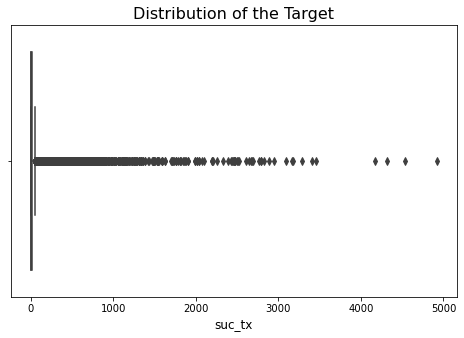

In [82]:
plt.figure(figsize=(8,5))
sns.boxplot(suc_tx.suc_tx)

plt.title('Distribution of the Target', fontsize=16)
plt.xlabel('suc_tx', fontsize=12);

plt.savefig('assets/target-dist-fig4.jpeg', bbox_inches='tight')

The target seems to be heavily skewed and there are a lot of outliers in the data. However, upon investigation it was found that these outliers were actual data points and not errors therefore it doesn't make sense to exlcude them from the analysis.

Moreover, since the data is not normally distributed and due to lack of linear relationships between the target and the independant variables, we'll employ a tree based model.

Let's split the dataset into training and testing sets. Due to a huge amount of data and limited time, we'l only split the dataset into a train and test set.

In [63]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, 
                                                    test_size=0.30, 
                                                    random_state=42)

Now, training our Decision Tree Regressor

In [64]:
dt = tree.DecisionTreeRegressor(max_depth=7, random_state=49)
dt.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=7, random_state=49)

In [66]:
np.sqrt(metrics.mean_squared_error(y_test, dt.predict(x_test)))

20.63432191870685

Here's look at the feature importances

Feature: cnt_uid || Score: 0.804
Feature: activedays || Score: 0.049
Feature: tx || Score: 0.147


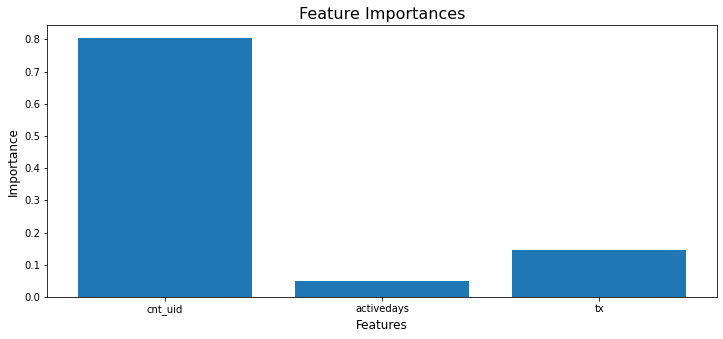

In [87]:
importance = dt.feature_importances_
for i,v in enumerate(importance):
    print(f'Feature: {x_train.columns[i]} || Score: {v:.3f}')

plt.figure(figsize=(12, 5))
plt.bar([x_train.columns[i] for i in range(len(importance))], importance)

plt.title('Feature Importances', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.savefig('assets/feature_imp-fig5.jpeg', bbox_inches='tight')

Interestingly, the number of distinct persons with whom a customer has engaged is ranked highest, while the number of days a it has been active on the network is ranked lowest.

### Conclusion

- Cluster 1 was identified as a persona with the high value and more distinct transactions. This persona also interacts with new people more.
- Cluster 2 consists of moderately engaged customers, an important goal for the business here would be to try to move these users into Cluster 1 by leveraging marketing efforts.
- My first suggestion in order to drive the count and value of a successful transactions would be to improve the quality of the data by adding in features that determines the major reason behind an unsuccesful transaction.
- Furthermore, as seen above, the value of a transaction has a strong positive correlation with the count, implying that enhancing one can boost the other.
- Encouraging a customer to make more unique transactions will help boost the number of successful transactions, therefore enhancing the value of a transaction.